## This is a exploration of the modelling techniques 

In [15]:
 # Importing necessary libraries
import pandas as pd
import numpy as np
import os
import psycopg2
from sqlalchemy import create_engine
from psycopg2 import OperationalError
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import Ridge
from ngboost import NGBRegressor
from ngboost.distns import Normal
from sklearn.metrics import  confusion_matrix , precision_score , recall_score , f1_score, roc_curve, auc
from sklearn.metrics import mean_squared_error 
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as smtpipeline
from sklearn.pipeline import Pipeline as sklpipeline
from sklearn.compose import ColumnTransformer


In [3]:
load_dotenv()

 # Connecting to the database 
engine = create_engine(
    f"postgresql+psycopg2://{os.getenv('user')}:{os.getenv('password')}@{os.getenv('host')}:{os.getenv('port')}/{os.getenv('database')}"
    )

In [4]:
 # importing the tables
try:
    DATA = pd.read_sql("SELECT * FROM transactions_train_raw", engine)
    print(" DATA SUCCESFULLY LOADED ")
except Exception as e:
        print(" ERROR : COULD NOT LOAD DATA FROM DATABASE : ", e)

 DATA SUCCESFULLY LOADED 


In [5]:
display(DATA)

,transaction_id,time_seconds,v1,v2,v3,v4,v5,v6,v7,v8,...,v22,v23,v24,v25,v26,v27,v28,ammount,fraud,timestamp
0,1,161919,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,...,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.32,0,2025-09-21 20:58:39
1,2,124477,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,...,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.99,0,2025-09-21 10:34:37
2,3,41191,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,...,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.10,0,2025-09-20 11:26:31
3,4,132624,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,...,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.10,0,2025-09-21 12:50:24
4,5,59359,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,...,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.10,0,2025-09-20 16:29:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227840,227841,147710,1.993864,-0.516866,-0.620118,0.129845,-0.285128,0.395044,-0.822358,0.231591,...,0.884510,0.099141,0.275689,-0.195404,0.623598,-0.032455,-0.058552,5.99,0,2025-09-21 17:01:50
227841,227842,60764,-1.497933,0.657921,1.581568,-0.024286,0.584698,1.303031,0.609212,0.135561,...,0.299172,0.110048,-0.615980,-0.425883,0.263968,-0.448445,0.045178,36.99,0,2025-09-20 16:52:44
227842,227843,35301,1.069777,0.072105,0.496540,1.505318,-0.380277,-0.370243,0.100551,-0.026687,...,-0.044629,-0.050485,0.400171,0.593314,-0.335160,0.031014,0.024886,45.42,0,2025-09-20 09:48:21
227843,227844,24413,1.280465,0.300586,0.333044,0.512720,0.065052,-0.145844,-0.145519,-0.091833,...,-0.961351,0.033153,-0.560429,0.278428,0.089546,-0.059835,-0.005887,0.89,0,2025-09-20 06:46:53


We have succesfully loaded the Training dataset that has 227 rows and 33 columns 

In [12]:
 # Dividing the data into train and test data 
X = DATA.iloc[ :,2:-2 ]
y = DATA.iloc[ :,-2 ]

 # Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
75 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HomePC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-

Best Parameters :  {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV f1 score :  0.7504252020929343
CLASSIFICATION REPOT
classification report :  (58579     0
9570      0
147325    0
168404    0
16726     0
         ..
147399    0
54479     0
78338     0
167357    0
36364     0
Name: fraud, Length: 45569, dtype: int64, array([0, 0, 0, ..., 0, 0, 0]))
Precision: 0.8181818181818182
Recall: 0.5294117647058824
F1 Score: 0.6428571428571429
Confusion Matrix:
 [[45493     8]
 [   32    36]]


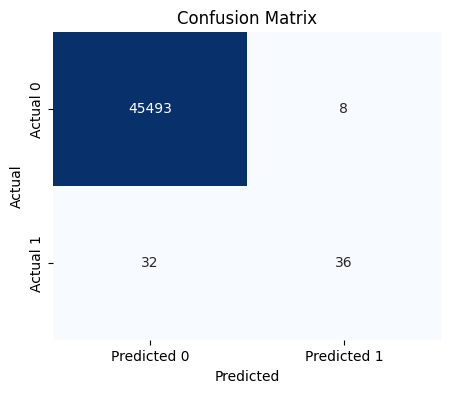

In [ ]:
 # Pipeline for modelling using logistic regression(without handling imbalance)
 # Scalling ammount column
scaled_col = ['ammount']

processor = ColumnTransformer(
    transformers = [
        ('scale_column', StandardScaler(), scaled_col )
    ],
    remainder = 'passthrough'
)

 # pipeline
pipe = sklpipeline([
    ('processor', processor),
    ('clf', LogisticRegression( max_iter=1000 ))
])

param_grid = [
    {'clf__penalty':['l2','none'],
    'clf__C' : [0.1,1,10],
    'clf__solver': ['lbfgs']
}
]

 # cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    scoring = 'f1',
    cv = skf,
    n_jobs = 1,
    verbose = 1

)

grid.fit(X_train, y_train)
print('Best Parameters : ', grid.best_params_)
print('Best CV f1 score : ', grid.best_score_)

 # Evaluation
best_model1= grid.best_estimator_
y_pred1 = best_model1.predict(X_test)
y_pred1_prob = best_model1.predict_proba(X_test)[:,1]
precision = precision_score(y_test, y_pred1)
recall = recall_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred1)

print('CLASSIFICATION REPOT')
print('classification report : ', (y_test, y_pred1))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)

# Heatmap for Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [7]:
 # Scalling the Ammount column
scaler = StandardScaler()
X['ammount'] = scaler.fit_transform(X[['ammount']])

In [ ]:
 # Modelling using logistic regression  


# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
f_score = f1_score(y_test,y_pred)

# Print the mean metrics
print('**** PERFORMANCE MATRICES BASELINE MODEL****')
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("f_score: {:.2f}%".format(f_score * 100))

# Cross Validation
model1 = LogisticRegression() 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precision_scores_list = []
recall_scores_list = []
f_scores_list = []

# Perform stratified K-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train1, X_test1 = X.iloc[train_index], X.iloc[test_index]
    y_train1, y_test1 = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred1 = model.predict(X_test1)
    precision_scores_list.append(precision_score(y_test1, y_pred1))
    recall_scores_list.append(recall_score(y_test1, y_pred1))
    f_scores_list.append(f1_score(y_test1, y_pred1))

# Print the mean metrics
print('**** PERFORMANCE MATRICES FROM CROSS VALIDATION ****')
print(f"Mean precision: {(sum(precision_scores_list) / len(precision_scores_list)*100):.4f}")
print(f"Mean recall {(sum(recall_scores_list) / len(recall_scores_list)*100):.4f}")
print(f"Mean f1 score: {(sum(f_scores_list) / len(f_scores_list)*100):.4f}")



**** PERFORMANCE MATRICES BASELINE MODEL****
Precision: 80.95%
Recall: 50.00%
f_score: 61.82%
**** PERFORMANCE MATRICES FROM CROSS VALIDATION ****
Mean precision: 87.6989
Mean recall 62.6874
Mean f1 score: 73.0803


In [9]:
 # Modelling using smote 
smote_pipe = smtpipeline([
    ('Smote', SMOTE(random_state= 42)),
    ('clf',LogisticRegression())
]) 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision',
    'avg_precision': 'average_precision'
}

results = cross_validate(
    smote_pipe, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1
)

for metric in scoring:
    mean = results[f'test_{metric}'].mean()*100
    print(f"{metric:15s}: {mean:.3f}")

roc_auc        : 98.044
f1             : 10.807
recall         : 90.617
precision      : 5.748
avg_precision  : 75.191
